### Import Library yang akan digunakan

In [122]:
import pandas as pd
import re
import string
import nltk
from transformers import pipeline
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
from tensorflow.keras.optimizers import Adam
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

### Memuat Data Tweet

In [3]:
link = "https://raw.githubusercontent.com/HaikalAkbar13/dicoding_sentimen_analysis/refs/heads/main/tweets_data.csv"
df = pd.read_csv(link)
df.columns

Index(['Tweet ID', 'Tweet Time Stamp', 'Tweet Text', 'Tweet Hashtag',
       'Tweet Translated'],
      dtype='object')

### Assesing dan Cleaning Data

In [4]:
# Drop kolom yang tidak di butuhkan (Timestamp, Tweet Text, Hashtag)
df = df.drop(columns=['Tweet Time Stamp', 'Tweet Text', 'Tweet Hashtag'])
df.head()

,Tweet ID,Tweet Translated
0,1609172529712611329,The Embark Internship has allowed our interns ...
1,1609243867504590850,asked ChatGPT: What jobs will be needed for hu...
2,1609261573184581635,"Thanks to ChatGPT, I just learned a new skill!..."
3,1609043258625216512,"Maybe AI won't be taking our jobs... at least,..."
4,1608679261136912384,"Well, @openai #ChatGPT completely shit the bed..."


In [5]:
# Duplicate Value
print(f"Jumlah Duplicated Value sebelum di drop \n{df.duplicated().value_counts()}")
df = df.drop_duplicates()
print(f"Jumlah Duplicated Value setelah di drop \n{df.duplicated().value_counts()}")

Jumlah Duplicated Value sebelum di drop 
False    14073
True        33
Name: count, dtype: int64
Jumlah Duplicated Value setelah di drop 
False    14073
Name: count, dtype: int64


In [6]:
# Null Values
for column in df.columns:
    print(f"Jumlah Null Values pada kolom {column} : {df[column].isna().value_counts()}")

Jumlah Null Values pada kolom Tweet ID : Tweet ID
False    14073
Name: count, dtype: int64
Jumlah Null Values pada kolom Tweet Translated : Tweet Translated
False    14073
Name: count, dtype: int64


### Pre Processing Data

In [7]:
# Membuat Fungsi untuk Pre processing Data
def preprocessing(text):
    # Inisialisasi
    punctuation_set = set(string.punctuation)
    stop_words = set(stopwords.words('english'))
    lemma = WordNetLemmatizer()
    text = text.lower()
    # Strip whitespaces
    text = text.strip()
    # Hapus URL, mentions, hashtag, newline, angka, special characters
    text = re.sub(r"http\S+|www\.\S+|@\w+|#\w+|[^\d\w\S]|\d+|\W|\0|_+|[^\x00-\x7F]+", " ", text)
    # Hapus punctuation
    text = ''.join(char for char in text if char not in punctuation_set)
    # Tokenisasi dan hapus stopwords
    tokens = word_tokenize(text)
    filtered = [word for word in tokens if word not in stop_words]
    # Lemmatization
    text = [lemma.lemmatize(word) for word in filtered]
    text = " ".join(word for word in text)
    return text

In [8]:
df["Text Cleaned"] = df["Tweet Translated"].apply(preprocessing)
df.head(30)

,Tweet ID,Tweet Translated,Text Cleaned
0,1609172529712611329,The Embark Internship has allowed our interns ...,embark internship allowed intern grow professi...
1,1609243867504590850,asked ChatGPT: What jobs will be needed for hu...,asked chatgpt job needed human perform artific...
2,1609261573184581635,"Thanks to ChatGPT, I just learned a new skill!...",thanks chatgpt learned new skill
3,1609043258625216512,"Maybe AI won't be taking our jobs... at least,...",maybe ai taking job least yet
4,1608679261136912384,"Well, @openai #ChatGPT completely shit the bed...",well completely shit bed one pharmacologist bi...
5,1608963021824561154,“AI Rewrite: Steve Jobs Stanford Commencement”...,ai rewrite steve job stanford commencement pet...
6,1609304139116302339,🧵 How to replace bullshit jobs with AI 🧵 \n\n2...,replace bullshit job ai year never seen risk o...
7,1609301436428423174,Four Ways #Jobs Will Respond to #Automation \n...,four way respond via
8,1608996363123007489,BGSU program to meet critical workforce needs ...,bgsu program meet critical workforce need adva...
9,1608952318787026947,New books from MIT experts deliver insights on...,new book mit expert deliver insight future rea...


### Labeling Data

In [18]:
# Labeling data menggunakan Model dari Hugging Face
label = ["Positive", "Neutral", "Negative"]
model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
cls = pipeline("sentiment-analysis",
                      model=model_name, tokenizer=model_name, device=0)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


In [28]:

def labelling_batch(texts):
    results = cls(texts)
    return [res["label"].capitalize() for res in results]

# Proses batch
batch_size = 32
sentiments = []
for i in tqdm(range(0, len(df), batch_size)):
    batch = df["Text Cleaned"][i:i+batch_size].tolist()
    sentiments.extend(labelling_batch(batch))

df["Sentiment"] = sentiments
df.head()

100%|██████████| 440/440 [02:26<00:00,  3.00it/s]


,Tweet ID,Tweet Translated,Text Cleaned,Sentiment
0,1609172529712611329,The Embark Internship has allowed our interns ...,embark internship allowed intern grow professi...,Positive
1,1609243867504590850,asked ChatGPT: What jobs will be needed for hu...,asked chatgpt job needed human perform artific...,Neutral
2,1609261573184581635,"Thanks to ChatGPT, I just learned a new skill!...",thanks chatgpt learned new skill,Positive
3,1609043258625216512,"Maybe AI won't be taking our jobs... at least,...",maybe ai taking job least yet,Neutral
4,1608679261136912384,"Well, @openai #ChatGPT completely shit the bed...",well completely shit bed one pharmacologist bi...,Negative


In [71]:
data = df["Sentiment"].groupby(df["Sentiment"]).count()
data

,Sentiment
Sentiment,
Negative,1875
Neutral,9882
Positive,2316


In [34]:
def model_eval(model, X_test, y_test):
    hasil = model.predict(X_test)
    hasil_skor = {
        "Akurasi" : accuracy_score(y_test, hasil),
        "Presisi" : precision_score(y_test, hasil, average="macro"),
        "Recall" : recall_score(y_test, hasil, average="macro"),
        "F1 Score" : f1_score(y_test, hasil, average="macro")
    }
    return hasil_skor

### Membangun Model dan Evaluasi Model

- Model 1 : Decision Tree
  - Metode Ekstraksi Fitur : TF-IDF
  - Pembagian Data : 70/30

In [123]:
tfidf = TfidfVectorizer(max_features=3000)
smote = SMOTE()
X = tfidf.fit_transform(df["Text Cleaned"])
y = df["Sentiment"]

In [124]:
X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_dt, y_train_dt = smote.fit_resample(X_train_dt, y_train_dt)
# Decision Tree
dt = DecisionTreeClassifier()
dt.fit(X_train_dt, y_train_dt)

DecisionTreeClassifier()

In [125]:
result_train = model_eval(dt, X_train_dt, y_train_dt)
result_test = model_eval(dt, X_test_dt, y_test_dt)

data_score_dt = pd.DataFrame({
    "Train/Test Decision Tree": ["Train", "Test"],
    "Akurasi": [result_train["Akurasi"], result_test["Akurasi"]],
    "Presisi": [result_train["Presisi"], result_test["Presisi"]],
    "Recall": [result_train["Recall"], result_test["Recall"]],
    "F1 Score": [result_train["F1 Score"], result_test["F1 Score"]]
})
data_score_dt

,Train/Test Decision Tree,Akurasi,Presisi,Recall,F1 Score
0,Train,0.999181,0.999181,0.999181,0.999181
1,Test,0.670062,0.539190,0.553591,0.545588


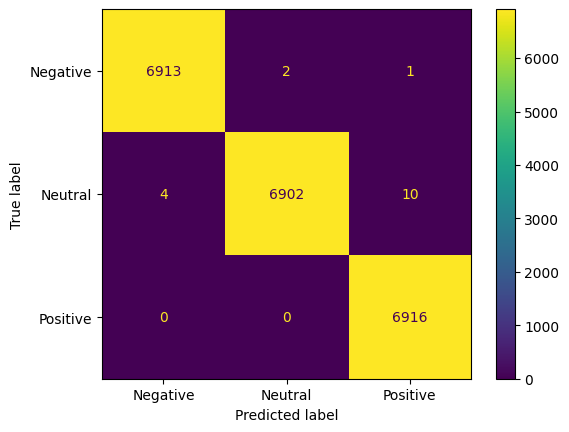

In [126]:
# Confusion Matrix untuk hasil Train
ConfusionMatrixDisplay.from_estimator(dt, X_train_dt, y_train_dt)

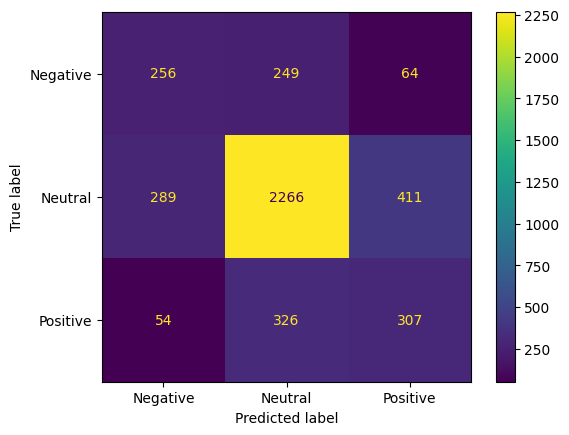

In [127]:
# Confusion Matrix untuk hasil Test
ConfusionMatrixDisplay.from_predictions(y_test_dt, dt.predict(X_test_dt))

- Model 2 : Random Forest
  - Metode Ekstraksi Fitur : TF-IDF
  - Pembagian Data : 60/40

In [128]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X, y, test_size=0.4, random_state=42)
X_train_rf, y_train_rf = smote.fit_resample(X_train_rf, y_train_rf)
# Random Forest Model
rf = RandomForestClassifier()
rf.fit(X_train_rf, y_train_rf)

RandomForestClassifier()

In [129]:
result_train = model_eval(rf, X_train_rf, y_train_rf)
result_test = model_eval(rf, X_test_rf, y_test_rf)

data_score_rf = pd.DataFrame({
    "Train/Test Random Forest": ["Train", "Test"],
    "Akurasi": [result_train["Akurasi"], result_test["Akurasi"]],
    "Presisi": [result_train["Presisi"], result_test["Presisi"]],
    "Recall": [result_train["Recall"], result_test["Recall"]],
    "F1 Score": [result_train["F1 Score"], result_test["F1 Score"]]
})
data_score_rf

,Train/Test Random Forest,Akurasi,Presisi,Recall,F1 Score
0,Train,0.999267,0.999268,0.999267,0.999267
1,Test,0.747069,0.643836,0.576596,0.602081


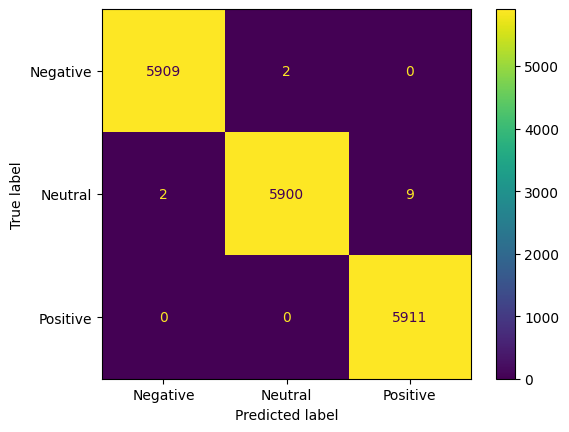

In [130]:
# Confusion Matrix untuk hasil Train
ConfusionMatrixDisplay.from_estimator(rf, X_train_rf, y_train_rf)

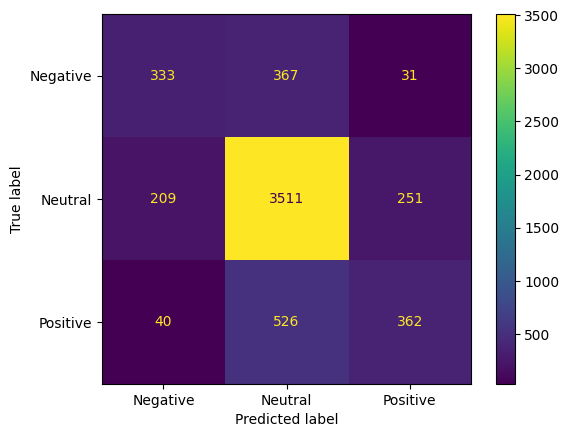

In [131]:
# Confusion Matrix untuk hasil Test
ConfusionMatrixDisplay.from_predictions(y_test_rf, rf.predict(X_test_rf))

- Model 3 : Neural Network
  - Metode Ekstraksi Fitur : TF-IDF
  - Pembagian Data : 50/50

In [132]:
# Encoding Label
le = LabelEncoder()
y_encode = le.fit_transform(y)
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(X, y_encode, test_size=0.5, random_state=42)
X_train_nn, y_train_nn = smote.fit_resample(X_train_nn, y_train_nn)
# Inisialisasi NN
model_nn = Sequential([
    Dense(512, activation='relu', input_shape=(X_train_nn.shape[1],)),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

model_nn.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_nn.fit(X_train_nn, y_train_nn,
          epochs=10,
          batch_size=64,
          validation_data=(X, y_encode),
          verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 786ms/step - accuracy: 0.4279 - loss: 1.0800

KeyboardInterrupt: 